# EDA and Cleaning

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pandas as pd

module_path = os.path.abspath(os.path.join(os.pardir, 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from modules import dataloading as dl
from modules import Viz

import matplotlib.pyplot as plt
import seaborn as sns

targetdir = "../data/extracted/"
figtargetdir = "../images/"

## Liquid net worth generally

This section aims to show the distribution of liquid net worth generally under `lqd_assets`. What an initial Pandas describe shows is that it appears there is an extreme skew as even from the 75th percentile to the maximum value there is an increase of the order of magnitude by 3. The next step would be to visualize this.

In [2]:
df = pd.read_stata(targetdir + 'scf2019s/p19i6.dta', columns=dl.sel_vars)
df.columns = [x.lower() for x in df.columns]
df.rename(columns=dl.rename_dict, inplace=True)
df = dl.clean_SCF_df(df)
df.head()

,weighting,persons_in_PEU,spouse_part_of_PEU,ref_age,spouse_age,ref_sex,spouse_sex,ref_race,ref_educ,spouse_educ,...,bachelor_deg,assoc_deg,hs_deg,educ_bins_s,doctorate_deg_s,master_deg_s,bachelor_deg_s,assoc_deg_s,hs_deg_s,1k_target
household_id,,,,,,,,,,,,,,,,,,,,,
1,26037.0,1.0,1.0,75.0,0.0,2.0,0.0,1.0,12.0,0.0,...,1,0,0,0,0,0,0,0,0,1
2,18970.0,5.0,2.0,50.0,39.0,1.0,2.0,1.0,8.0,8.0,...,0,0,0,1,1,0,0,0,0,0
3,20483.0,2.0,2.0,53.0,49.0,1.0,2.0,1.0,8.0,8.0,...,0,0,0,1,1,0,0,0,0,1
4,31785.0,2.0,2.0,29.0,28.0,1.0,2.0,1.0,13.0,14.0,...,0,1,0,5,0,0,0,0,1,1
5,21046.0,2.0,2.0,47.0,39.0,1.0,2.0,1.0,8.0,8.0,...,0,0,0,1,1,0,0,0,0,0


## Liquid Assets Viz

Below is a cumulative distribution function of the liquid net worth of U.S. households. Weights are used to account for the fact that the dataset oversamples more well-off households. That can be seen in the second graph which shows that at the \$1,000 mark, the  number of people that have at most that mount of money increases from about 20% to about 24%. And on the higher end of the wealth spectrum, you can see that there is an even greater increase of people that have at most \\$100,000 in liquid net worth.

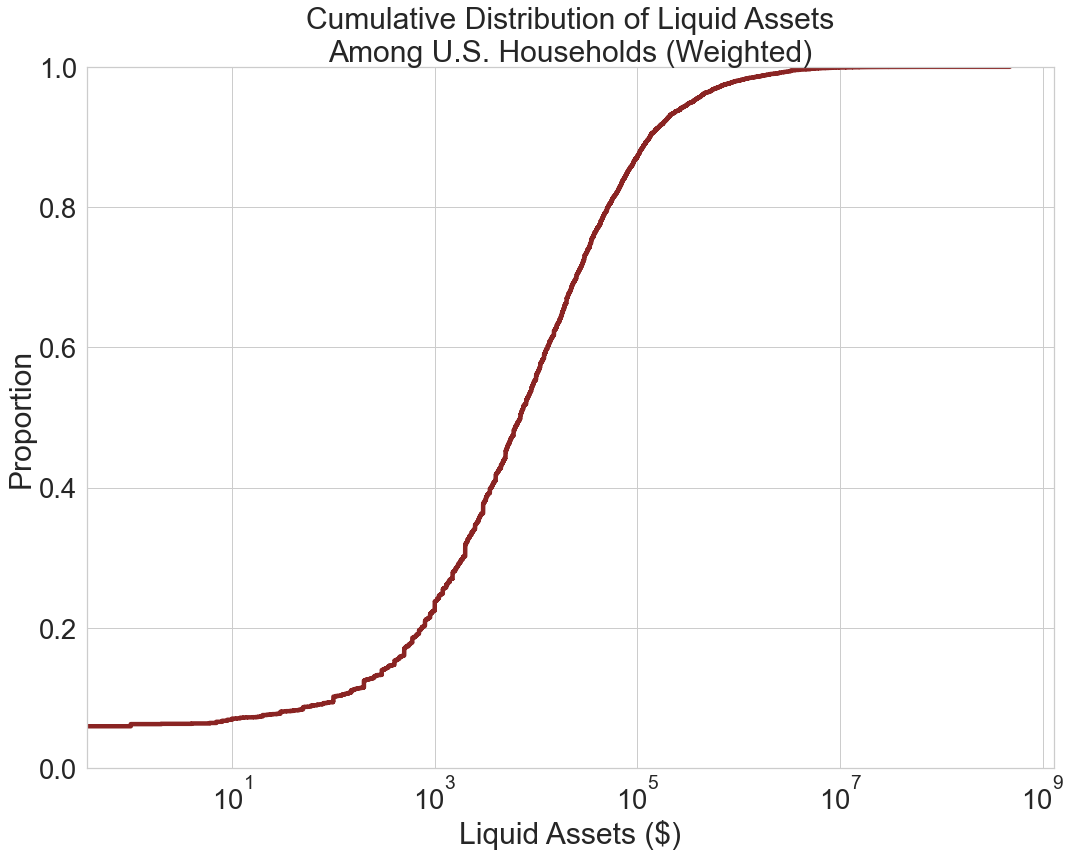

In [3]:
Viz.lqdassetsViz(df, figtargetdir, stat="proportion", weighted=True)

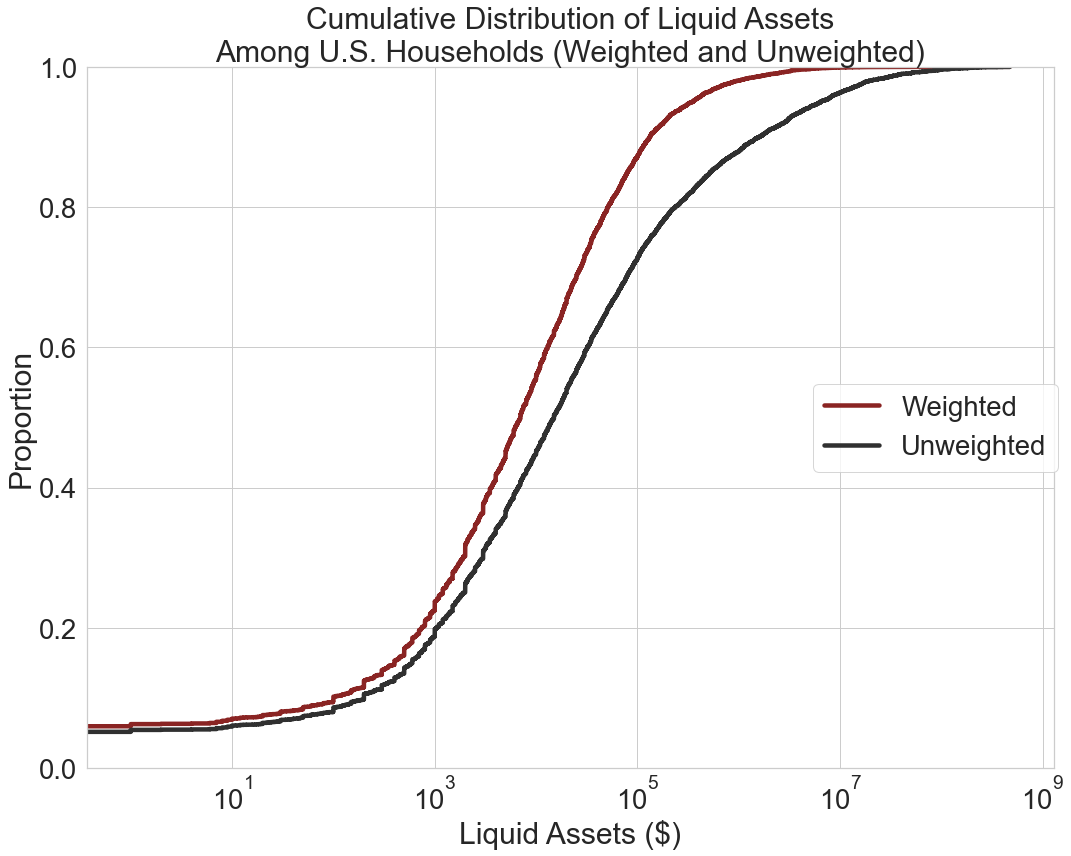

In [4]:
Viz.lqdassetsViz(df, figtargetdir, stat = "proportion", weighted=True, both=True)

## `1k_target` analysis

This section analyzes the variable that the model will target, which is an indicator variables showing whether a household has at least \$1,000 in liquid assets to invest with Vanguard.

### Counts

The two calculations below confirm the visual estimates done above: the weighted data shows that about 24% of the population has at most \$1,000. 

In [5]:
# Unweighted
vcs_uw = df['1k_target'].value_counts()

#proportion of non-target population
vcs_uw[0]/vcs_uw.sum()

0.1971611563095032

In [6]:
# Weighted
vcs_w = df.groupby('1k_target').weighting.sum()


# proportion of non-target population
vcs_w[0]/vcs_w.sum()

0.2359969473209668

### Breakdown of lqd_assets

An attempt is made to show how much total assets is within each class of households. The calculations below show a class imbalance in another sense: those in the bottom 20% of the distribution of liquid assets collectively have 0.06% of all of liquid assets. This may imply that there are more ways to have lots of money than there are ways to have no money.

In [7]:
df['lqd_assets_w'] = df.lqd_assets * df.weighting

# Total amount of liquid assets outside of target
tot_nontarget = df.groupby('1k_target').lqd_assets_w.sum()[0] #9.42 bn weighted
tot_nontarget_str = '{:,.2f}'.format(tot_nontarget)
print(tot_nontarget_str)
# total potential fees collected by vanguard multiplying total lqd_assets by avg mutual fund rate
print(f"Potential fees: {tot_nontarget*.001}") # 9.5 mm

9,488,564,438.00
Potential fees: 9488564.438000001


In [8]:
# Total amount of liquid assets within target
tot_target = df.groupby('1k_target').lqd_assets_w.sum()[1] #15 tn weighted
tot_target_str = '{:,.2f}'.format(tot_target)
print(tot_target_str)

# total potential fees collected by vanguard multiplying total lqd_assets by avg mutual fund rate
print(f"Potential fees: {tot_target*.001}") # 15 bn

15,225,776,464,271.00
Potential fees: 15225776464.271


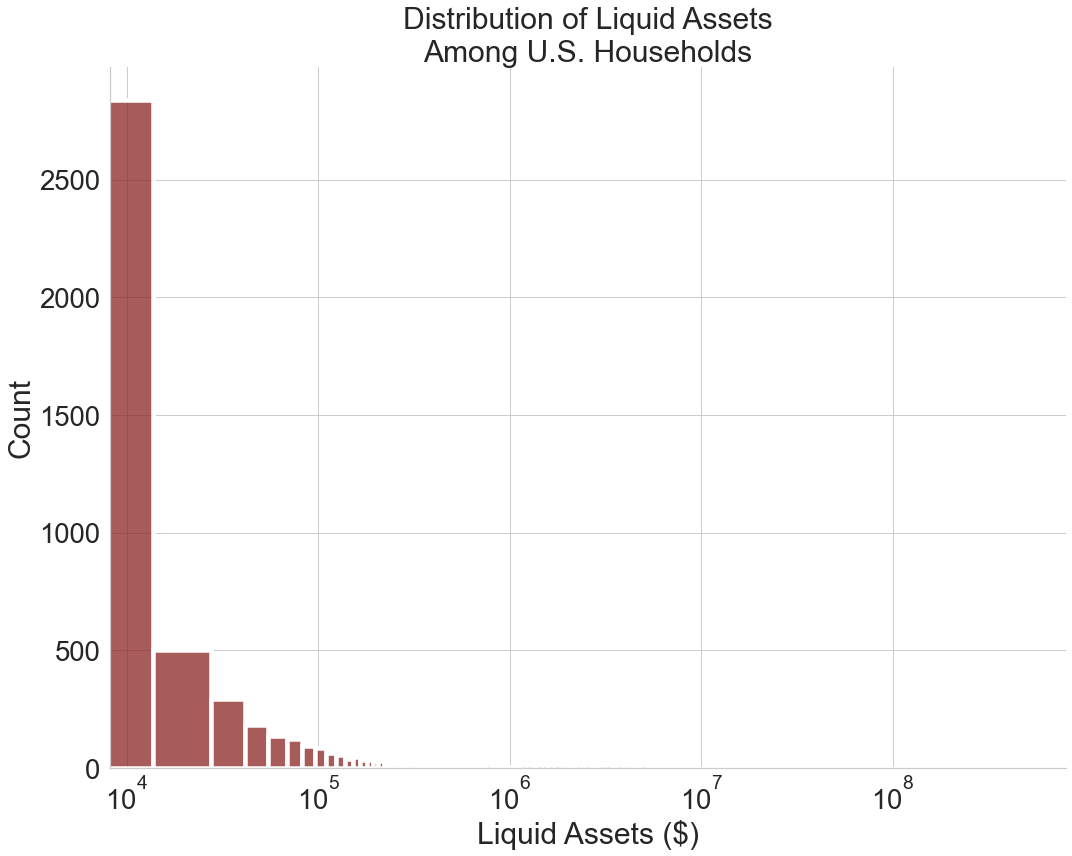

In [9]:
Viz.lqdassetsViz2(df, figtargetdir)

In [10]:
# Share of total liquid assets of non-target population
(tot_nontarget / (tot_nontarget + tot_target))*100

0.062280271594356625

In [11]:
# multiplier
tot_target / tot_nontarget

1604.6448926767566

### Age and Education

In [12]:
df.ref_age.describe()

count    5777.000000
mean       53.219837
std        16.244778
min        18.000000
25%        40.000000
50%        54.000000
75%        65.000000
max        95.000000
Name: ref_age, dtype: float64

In [13]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

df['age_bins'] = pd.cut(x=df['ref_age'], bins=[17, 29, 45, 59, 75, 95])

In [14]:

df['age_bins'].value_counts()

(59, 75]    1724
(45, 59]    1655
(29, 45]    1422
(17, 29]     499
(75, 95]     477
Name: age_bins, dtype: int64

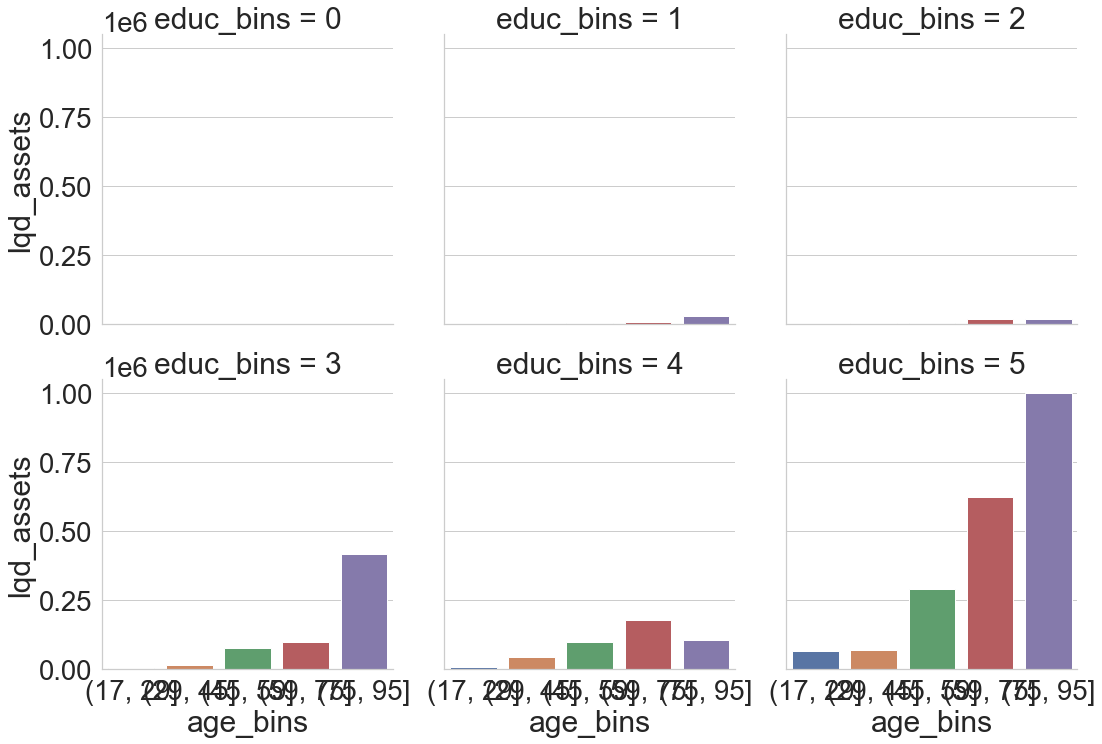

In [15]:
sns.catplot(x="age_bins",
            y='lqd_assets',
            col="educ_bins", 
            col_wrap=3,
            data=df,
            kind='bar',
            ci=None,
            estimator=np.median
           )

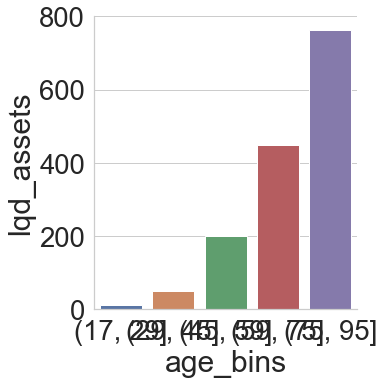

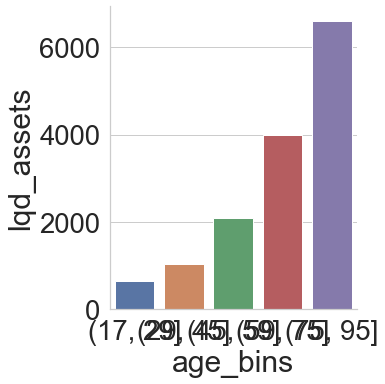

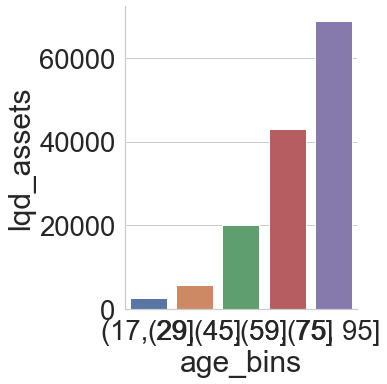

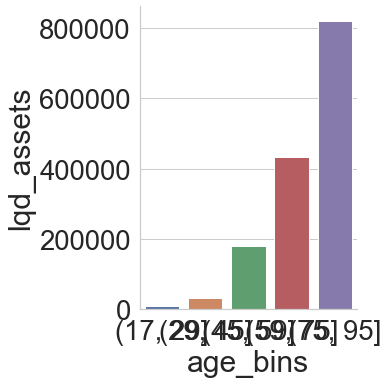

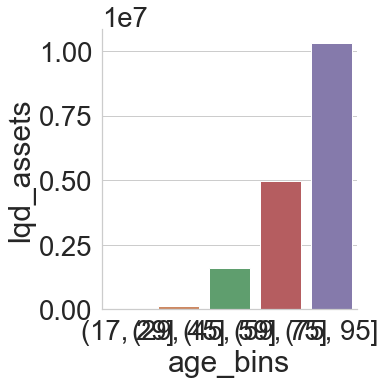

In [16]:

def make_f(i):
    def my_func(x, q=i, **kws):
        quant = np.quantile(x, q)
        return quant
    return my_func

func_dict = {}   
for q in [.1, .25, .5, .75, .9]:
    func_dict[q] = make_f(q)
    
    
for i in func_dict:
    sns.catplot(x="age_bins",
                y='lqd_assets',
                data=df,
                kind='bar',
                estimator=func_dict[i],
                ci=None
               )

## Checking and cleaning cat vars

In [17]:
df = pd.read_stata(targetdir + 'scf2019s/p19i6.dta', columns=dl.sel_vars)
df.columns = [x.lower() for x in df.columns]
df.rename(columns=dl.rename_dict, inplace=True)
df = dl.clean_SCF_df(df, neg_vals=True)


# Variables with negative values
negs_dict = {'dfs': {}, 'value_counts': {}}
for col in df:
    if df[col].min() < 0:
        negs_dict['dfs'][col] = df[df[col] < 0]
        negs_dict['value_counts'][col] = df[df[col] < 0][col].value_counts()
        
negs_dict.keys()
    

dict_keys(['dfs', 'value_counts'])

These are all of the variables that seem to have negative values, which should not be the case. Investigating case-by-case below.

### `ref_race`

In [18]:
var = 'ref_race'
negs_dict['value_counts'][var]

-7.0    335
Name: ref_race, dtype: int64

In [19]:
df[df[var] == -7.0].index

Int64Index([  20,   25,   33,   46,   59,   69,   78,   97,  151,  168,
            ...
            5615, 5631, 5643, 5654, 5683, 5715, 5737, 5755, 5778, 5811],
           dtype='int64', name='household_id', length=335)

In [20]:
og_df = pd.read_stata('../data/extracted/scf2019s/p19i6.dta', columns=dl.sel_vars)
og_df.columns = [x.lower() for x in og_df.columns]
og_df.rename(columns=dl.rename_dict, inplace=True)
og_df.head()

,household_id,weighting,persons_in_PEU,spouse_part_of_PEU,ref_age,spouse_age,ref_sex,spouse_sex,ref_race,ref_educ,...,x3748,x3754,x3760,x3765,x3732,x3738,x3744,x3750,x3756,x3762
0,1,30598.896539,1,1,75,0,2,0,1,12,...,0,0,0,0,0,0,0,0,0,0
1,1,23561.874562,1,1,75,0,2,0,1,12,...,0,0,0,0,0,0,0,0,0,0
2,1,25726.122276,1,1,75,0,2,0,1,12,...,0,0,0,0,0,0,0,0,0,0
3,1,26488.317060,1,1,75,0,2,0,1,12,...,0,0,0,0,0,0,0,0,0,0
4,1,23809.061856,1,1,75,0,2,0,1,12,...,0,0,0,0,0,0,0,0,0,0


In [21]:
og_df[og_df.household_id == 20][var]

95   -7
96   -7
97   -7
98   -7
99   -7
Name: ref_race, dtype: int8

-7 means other, so all of these households can go to 0. 


In [22]:
df[df[var] == -0.6].index

Int64Index([], dtype='int64', name='household_id')

In [23]:
og_df[og_df.household_id == 226][var]

1120    1
1121   -7
1122    1
1123    1
1124    1
Name: ref_race, dtype: int8

In [24]:
og_df[og_df.household_id == 233][var]

1155    1
1156    1
1157    1
1158    1
1159   -7
Name: ref_race, dtype: int8

For some reason the imputed dataset also seems to impute race to other in some cases. Anything that is not -7 for race may have to go to 1.

In [25]:
df[df[var] == -1.8].index

Int64Index([], dtype='int64', name='household_id')

In [26]:
og_df[og_df.household_id == 46][var]

225   -7
226    2
227    1
228   -7
229    2
Name: ref_race, dtype: int8

I think given the mixture of races in the imputed data for each HH and their relatively low number, all of these will go to 0.

### `ref_educ`

In [27]:
var = 'ref_educ'
negs_dict['value_counts'][var]

-1.0    9
Name: ref_educ, dtype: int64

-1 means less than first grade so these will go to 0.

### `spouse_educ`

In [28]:
var = 'spouse_educ'
negs_dict['value_counts'][var]

-1.0    6
Name: spouse_educ, dtype: int64

Same as `ref_educ`

### `total_income`

In [29]:
var = 'total_income'
negs_dict['value_counts'][var]

-9.0    36
-1.0     9
Name: total_income, dtype: int64

-1 is nothing and -9 is negative income generally, so all of these will go to 0. 

### `life_ins_cash_value`

In [30]:
var = 'life_ins_cash_value'
negs_dict['value_counts'][var]

-1.0    42
Name: life_ins_cash_value, dtype: int64

-1 is also nothing, so goes to 0. This is getting tedious. I've adjusted the dict. to show all value_counts and it looks like going to 0 for all of tehse is fine.

In [31]:
negs_dict['value_counts']

{'ref_race': -7.0    335
 Name: ref_race, dtype: int64, 'ref_educ': -1.0    9
 Name: ref_educ, dtype: int64, 'spouse_educ': -1.0    6
 Name: spouse_educ, dtype: int64, 'total_income': -9.0    36
 -1.0     9
 Name: total_income, dtype: int64, 'life_ins_cash_value': -1.0    42
 Name: life_ins_cash_value, dtype: int64, 'total_cc_limit': -1.0    12
 Name: total_cc_limit, dtype: int64, 'num_fin_inst': -1.0    137
 Name: num_fin_inst, dtype: int64, 'cc_newcharges_value': -1.0    290
 -2.0    169
 -3.0      8
 Name: cc_newcharges_value, dtype: int64, 'cc_currbal_value': -2.0    1222
 -1.0    1071
 -3.0     261
 Name: cc_currbal_value, dtype: int64, 'checking_accts_value': -1.0    53
 -2.0     5
 Name: checking_accts_value, dtype: int64, 'savings_accts_value': -1.0    8
 -2.0    3
 -5.0    1
 Name: savings_accts_value, dtype: int64, 'lqd_assets': -1.0    36
 -2.0     6
 Name: lqd_assets, dtype: int64}

## Cleaning

In [32]:
df = pd.read_stata(targetdir + 'scf2019s/p19i6.dta', columns=dl.sel_vars)
df.columns = [x.lower() for x in df.columns]
df.rename(columns=dl.rename_dict, inplace=True)
df = dl.clean_SCF_df(df, neg_vals=False, modeling=True)

In [33]:
df.head()

,persons_in_PEU,ref_age,spouse_age,total_income,total_cc_limit,freq_cc_payment,rev_charge_accts,num_fin_inst,LOC_owed_now,ed_loans_owed_now,...,spouse_occ_code_2.0,spouse_occ_code_3.0,spouse_occ_code_4.0,spouse_occ_code_5.0,spouse_occ_code_6.0,primary_home_type_3.0,primary_home_type_4.0,primary_home_type_5.0,income_comparison_2.0,income_comparison_3.0
household_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,75.0,0.0,52800.0,15000.0,1.0,0.0,4.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1
2,5.0,50.0,39.0,37800.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1
3,2.0,53.0,49.0,103000.0,1000.0,3.0,0.0,2.0,0.0,0.0,...,1,0,0,0,0,1,0,0,0,0
4,2.0,29.0,28.0,122000.0,55000.0,1.0,0.0,10.0,0.0,177000.0,...,0,0,0,0,0,1,0,0,0,1
5,2.0,47.0,39.0,29200.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,0


In [34]:
df.columns[0:81]

Index(['persons_in_PEU', 'ref_age', 'spouse_age', 'total_income',
       'total_cc_limit', 'freq_cc_payment', 'rev_charge_accts', 'num_fin_inst',
       'LOC_owed_now', 'ed_loans_owed_now', 'cc_newcharges_value',
       'cc_currbal_value', 'doctorate_deg', 'master_deg', 'bachelor_deg',
       'assoc_deg', 'hs_deg', 'doctorate_deg_s', 'master_deg_s',
       'bachelor_deg_s', 'assoc_deg_s', 'hs_deg_s', '1k_target',
       'spouse_part_of_PEU_2.0', 'ref_sex_2.0', 'spouse_sex_1.0',
       'spouse_sex_2.0', 'ref_race_1.0', 'ref_race_2.0', 'ref_race_3.0',
       'ref_UE_last_year_5.0', 'spouse_UE_last_year_5.0',
       'ref_industry_code_1.0', 'ref_industry_code_2.0',
       'ref_industry_code_3.0', 'ref_industry_code_4.0',
       'ref_industry_code_5.0', 'ref_industry_code_6.0',
       'ref_industry_code_7.0', 'spouse_industry_code_1.0',
       'spouse_industry_code_2.0', 'spouse_industry_code_3.0',
       'spouse_industry_code_4.0', 'spouse_industry_code_5.0',
       'spouse_industry_code_

In [35]:
# 